In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
#from torchvision.datasets.utils import TensorDataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
image_size = 64
stats = 0.5,0.5
tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [3]:
high_res = './grey_face_dataset/high_res/'
low_res = './grey_face_dataset/low_res/'

In [4]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, root1,root2, transform):
        super().__init__()
        self.root1 = root1
        self.root2 = root2
        self.transform = transform
        self.x = ImageFolder(self.root1,self.transform)
        self.y = ImageFolder(self.root2,self.transform)

    def __len__(self):
        return len(ImageFolder(self.root1))

    def __getitem__(self, idx): 

        return self.x[idx][0][0].unsqueeze(0), self.y[idx][0][0].unsqueeze(0)

In [5]:
dataset=CustomDataset(low_res,high_res,tfms)

In [7]:
%%time
dataset[0][0]

Wall time: 2 ms


tensor([[[ 0.8275,  0.8275,  0.8275,  ..., -0.3176,  0.1059,  0.8039],
         [ 0.8275,  0.8275,  0.8275,  ..., -0.3333,  0.3412,  0.8588],
         [ 0.8431,  0.8431,  0.8431,  ..., -0.2471,  0.5686,  0.8745],
         ...,
         [ 0.0353, -0.0118, -0.4039,  ..., -0.2314,  0.1686,  0.2157],
         [ 0.0588, -0.3333, -0.6863,  ..., -0.4588, -0.2863, -0.1922],
         [-0.1451, -0.4745, -0.6471,  ..., -0.4980, -0.5373, -0.5451]]])

In [8]:
val_size = 500
train_size = len(dataset) - val_size
torch.manual_seed(43)
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(59500, 500)

In [9]:
def denormalize(img_tensors):
    v=img_tensors
    v[0]=v[0] * stats[1] + stats[0]
    return v
def show_image(dl,dr):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_xticks([]); ax1.set_yticks([])
    ax1.imshow(denormalize(dl).permute(1, 2, 0), cmap='gray')
    ax2.set_xticks([]); ax2.set_yticks([])
    ax2.imshow(denormalize(dr).permute(1, 2, 0), cmap='gray')
    
    f.set_figheight(18)
    f.set_figwidth(18)

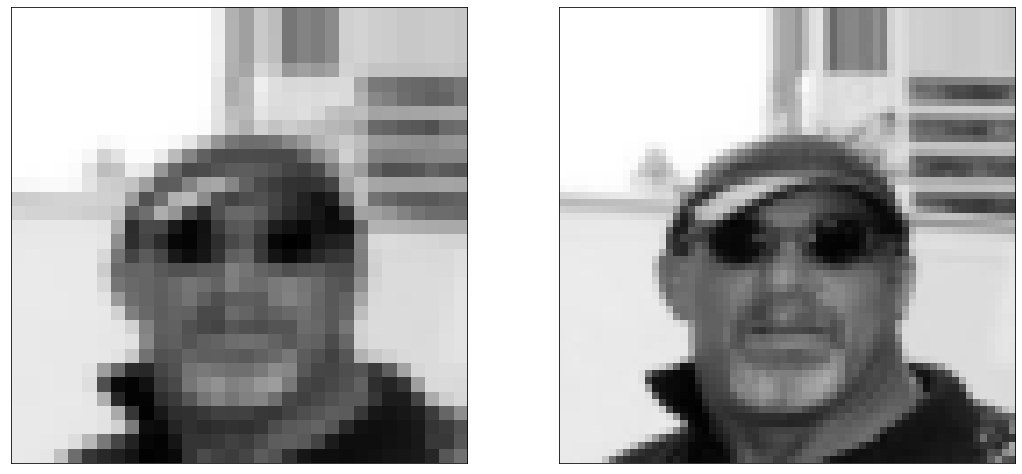

In [10]:
n=4011
show_image(train_ds[n][0],train_ds[n][1])

In [11]:
# PyTorch data loaders
batch_size = 90
train_dl = DataLoader(train_ds, batch_size, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [15]:
def conv_blockl(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.LeakyReLU(0.2, inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class discriminator(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.conv1 = conv_blockl(in_channels, 3, pool=False)#1*32*32
        self.conv2 = nn.Sequential(nn.ConvTranspose2d(3, 3, kernel_size=4, stride=2, padding=1, bias=False),
                                   nn.Tanh())#1*64*64
        self.conv3 = conv_blockl(3, 64, pool=True)#64*32*32
        self.conv4 = conv_blockl(64, 128, pool=True)#128*16*16
        self.conv5 = conv_blockl(128, 64, pool=True)#64*8*8
        self.conv6 = conv_blockl(64, 16, pool=True)#16*4*4
        self.conv7 = conv_blockl(16, 3, pool=True)#3*2*2
        self.conv8 = nn.Sequential(conv_blockl(3, 1, pool=True),#1*1*1
                                    #nn.Dropout(0.1),
                                    nn.Flatten(),
                                    nn.Sigmoid())
       
        
    def forward(self, yb):
        out = self.conv1(yb)
        out = self.conv2(out)
        #out = torch.cat((out.view(c.size(0), -1),
                          #yb.view(f.size(0), -1)), dim=1)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = self.conv8(out)
        return out

In [16]:
discriminator = to_device(discriminator(1), device)

In [16]:
discriminator.load_state_dict(torch.load('upscaler_discriminator.pth'))

<All keys matched successfully>

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
count_parameters(discriminator)

159867

In [19]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.PReLU()]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=False)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=False)
        self.conv4 = conv_block(256, 128, pool=False)
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.classifier = nn.Sequential(nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2, padding=1, bias=False),
                                        nn.ReLU(True),
                                        nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
                                        nn.Tanh())
                                        
       
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [20]:
generator = to_device(generator(1,1), device)

In [21]:
generator.load_state_dict(torch.load('upscaler_generator.pth'))

<All keys matched successfully>

In [21]:
count_parameters(generator)

1323049

In [22]:
def predict_image(img1,img2, model):
    # Convert to a batch of 1
    xb = to_device(img1.unsqueeze(0),device)
    yb = model(xb)
    yb=torch.squeeze(yb).unsqueeze(0)
    print(yb.detach().cpu().shape)
    show_image(img1,yb.detach().cpu())

torch.Size([1, 64, 64])


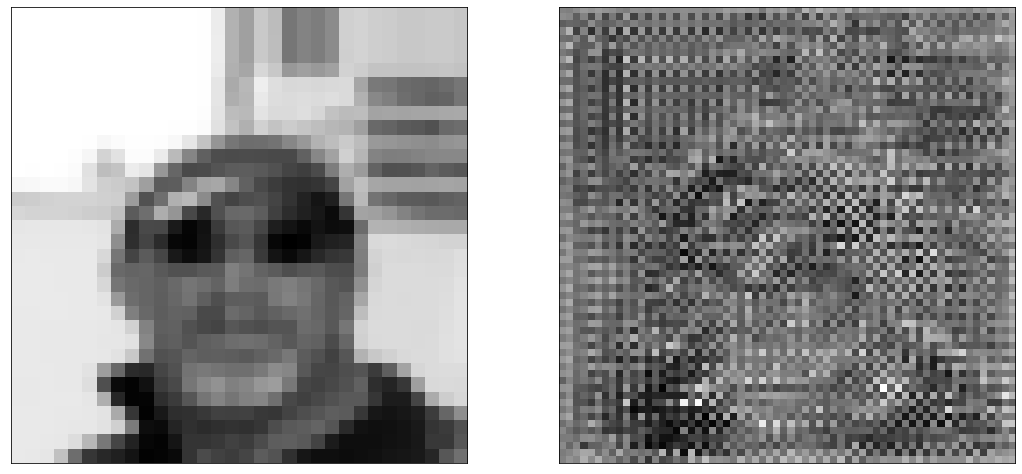

In [23]:
n=4011
predict_image(train_ds[n][0],train_ds[n][1],generator)

In [24]:
def train_discriminator(batch, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    inputs, targets = batch
    # Pass real images through discriminator
    real_preds = discriminator(inputs,targets)
    real_targets = torch.ones(inputs.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    fake_images = generator(inputs)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(inputs,fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [25]:
def train_generator(batch,opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    inputs,_ = batch
    # Generate fake images
    fake_images = generator(inputs)
    
    # Try to fool the discriminator
    preds = discriminator(inputs,fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [26]:
from torchvision.utils import save_image

In [27]:
sample_dir = 'Upscaled_images_gans3'
os.makedirs(sample_dir, exist_ok=True)

In [28]:
image=ImageFolder('./grey_face_dataset/low_res/',tfms)[0][0][0]

In [29]:
def save_samples(index,image, show=True):
    img=to_device(image.unsqueeze(0).unsqueeze(0),device)
    img=denormalize(torch.squeeze(generator(img)))
    img1=torch.zeros(3,64,64)
    img1[0]=img
    img1[1]=img
    img1[2]=img
    fake_fname = 'generated-images-{0:0=6d}.png'.format(index)
    save_image(img1, os.path.join(sample_dir, fake_fname))
    #save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        show_image(image.unsqueeze(0),img.detach().cpu().unsqueeze(0))

In [30]:
image.shape

torch.Size([32, 32])

Saving generated-images-000000.png


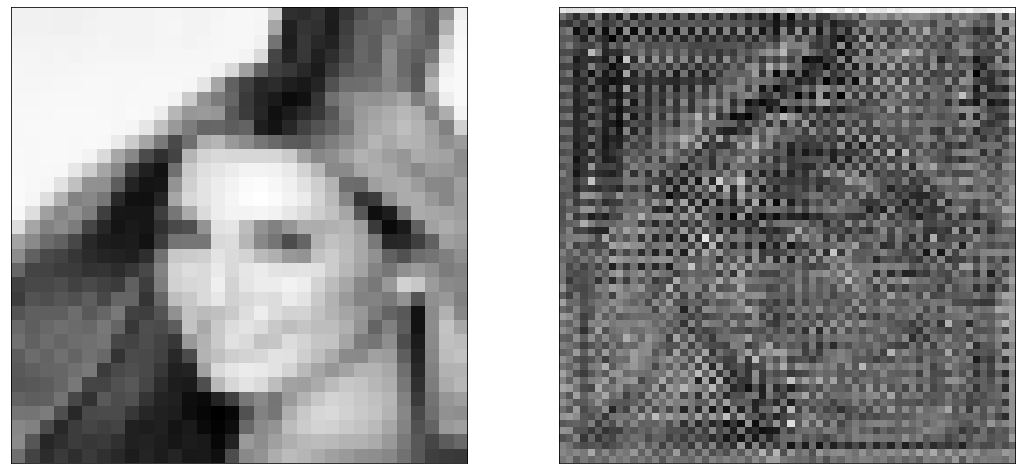

In [32]:
save_samples(0,image, show=True)

In [33]:
from tqdm.notebook import tqdm

In [34]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for batch in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(batch, opt_d)
            # Train generator
            loss_g = train_generator(batch,opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, image, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [35]:
lr = 0.0001
epochs = 10

In [36]:
%%time
history = fit(epochs, lr)

  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 0.5013, loss_d: 1.3878, real_score: 0.6493, fake_score: 0.6088
Saving generated-images-000001.png


  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 0.5243, loss_d: 1.3895, real_score: 0.6262, fake_score: 0.5945
Saving generated-images-000002.png


  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 0.5825, loss_d: 1.4105, real_score: 0.5584, fake_score: 0.5590
Saving generated-images-000003.png


  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 0.6645, loss_d: 0.9596, real_score: 0.8071, fake_score: 0.5239
Saving generated-images-000004.png


  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 0.6959, loss_d: 0.9085, real_score: 0.8191, fake_score: 0.5071
Saving generated-images-000005.png


  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 0.6979, loss_d: 0.8868, real_score: 0.8386, fake_score: 0.5082
Saving generated-images-000006.png


  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 0.7006, loss_d: 0.8531, real_score: 0.8498, fake_score: 0.4985
Saving generated-images-000007.png


  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 0.6541, loss_d: 0.9440, real_score: 0.8644, fake_score: 0.5462
Saving generated-images-000008.png


  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 0.3706, loss_d: 1.3968, real_score: 0.8670, fake_score: 0.6394
Saving generated-images-000009.png


  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 0.4924, loss_d: 1.2886, real_score: 0.8798, fake_score: 0.6369
Saving generated-images-000010.png
Wall time: 2h 49min 15s


In [42]:
lr = 0.0002
epochs = 5

In [43]:
%%time
history1 = fit(epochs, lr,11)

  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 0.6209, loss_d: 1.0941, real_score: 0.8860, fake_score: 0.6096
Saving generated-images-000011.png


  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 0.6093, loss_d: 1.0301, real_score: 0.9083, fake_score: 0.5983
Saving generated-images-000012.png


  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 0.7178, loss_d: 0.8087, real_score: 0.9093, fake_score: 0.5085
Saving generated-images-000013.png


  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 0.5172, loss_d: 1.2045, real_score: 0.9253, fake_score: 0.6210
Saving generated-images-000014.png


  0%|          | 0/662 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 0.7270, loss_d: 0.7304, real_score: 0.9340, fake_score: 0.4840
Saving generated-images-000015.png
Wall time: 1h 18min 35s


In [44]:
torch.save(generator.state_dict(), 'upscaler_generator2.pth')
torch.save(discriminator.state_dict(), 'upscaler_discriminator2.pth')

In [38]:
losses_g, losses_d, real_scores, fake_scores = history

torch.Size([1, 64, 64])


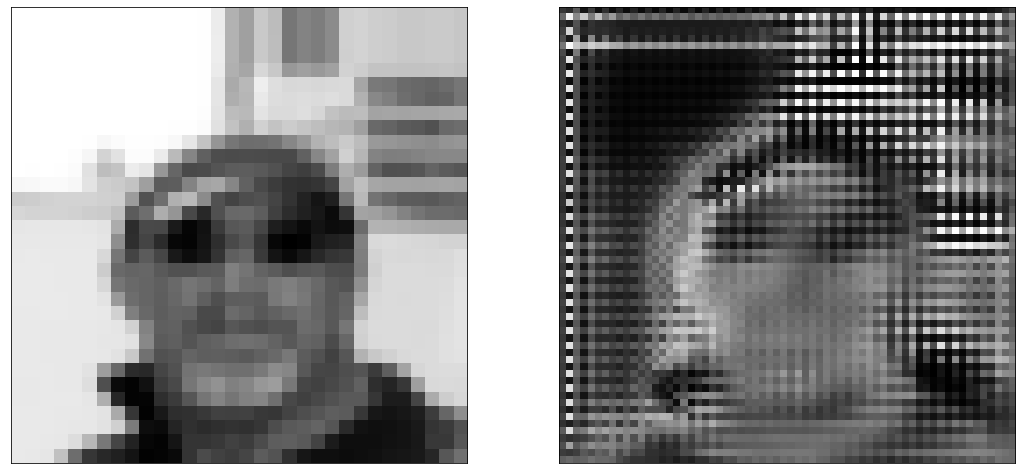

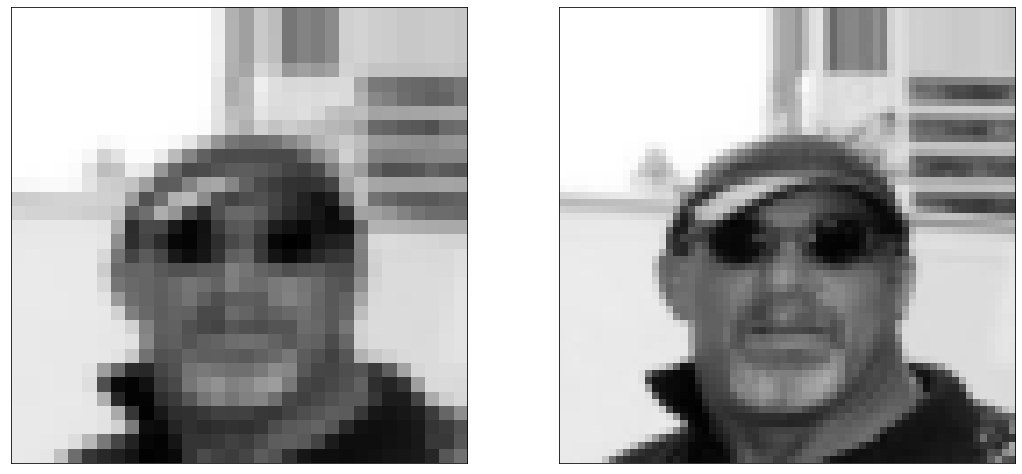

In [39]:
n=4011
predict_image(train_ds[n][0],train_ds[n][1],generator)
show_image(train_ds[n][0],train_ds[n][1])

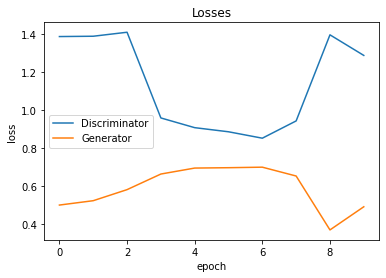

In [40]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

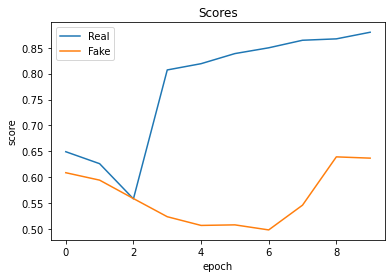

In [41]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [3]:
import cv2
import os

vid_fname = 'gans_training3.avi'

files = [os.path.join('Upscaled_images_gans3', f) for f in os.listdir('Upscaled_images_gans3') if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (64,64))
[out.write(cv2.imread(fname)) for fname in files]
out.release()